![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Introduction to Convolutional Neural Networks and Feature Visualization
In this Notebook we will briefly introduce the concept of Convolutional Neural Networks (CNNs) in machine learning and show you some examples of how to visualize kernels and feature maps.

---

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.


<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/HelmholtzSummerSchool-2024/xai-for-cnn/1-Tutorial_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
%rm -r XAI-Tutorials
!git clone --branch HelmholtzSummerSchool-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-cnn

### Imports

Let's start with importing all required Python packages.

In [2]:
# Installing the necessary packages
import torch
import torch.nn as nn

import cv2 as cv
import numpy as np

from torchvision import models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

--------

## CNNs and Feature Visualization

**We prepared a small [Introduction to Convolutional Neural Networks and Feature Visualization](https://xai-tutorials.readthedocs.io/en/latest/_ml_basics/CNN_feature_visualization.html) for you, to help you understand the main concepts.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_ml_basics/CNN_feature_visualization.html#references).*

### The Res-Net50 Model

Throughout this tutorial we will be using the ResNet-50 model. Take a minute now to look at the model's architecture.

<div>
<img src="https://www.mdpi.com/metals/metals-11-00388/article_deploy/html/images/metals-11-00388-g004.png" width="400" height="400"/>
</div>

<font size=1> Source: [Wang et al., 2021](https://www.mdpi.com/2075-4701/11/3/388)

To show you how features of a CNN model can be visualized, we will load the pre-trained ImageNet weights for the ResNet50 model. We will store the weights and names of the 49 convolutional layers (ResNet-50 has 50 layers: 49 convolutional layers, and the final fully connected layer) in `model_weights` and `conv_layers`. The `model.children()` module is a generator that returns layers of the model from which you can extract your parameter tensors using `layername.weight` or `layername.bias`.

In [4]:
# load the model
model = models.resnet50(pretrained=True)

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the conv layer names in this list

# get all the model children as list
model_children = list(model.children())

/Users/lisa.barros/anaconda3/envs/xai-test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lisa.barros/anaconda3/envs/xai-test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The ResNet architecture has many hidden and sequential layers, i.e. nestings of Bottleneck layers within different layers. To only keep the convolutional layers, check that the two conditions below are satisfied. Then, we append the child node and weights to `conv_layers` and `model_weights`, respectively.

In [5]:
# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


### Feature Maps

To visualize the filters of a convolutional layer, we iterate through the weights of the convolutional layer. The outputs are 64 filters, one for each hidden unit in the layer, of dimension 7×7. 

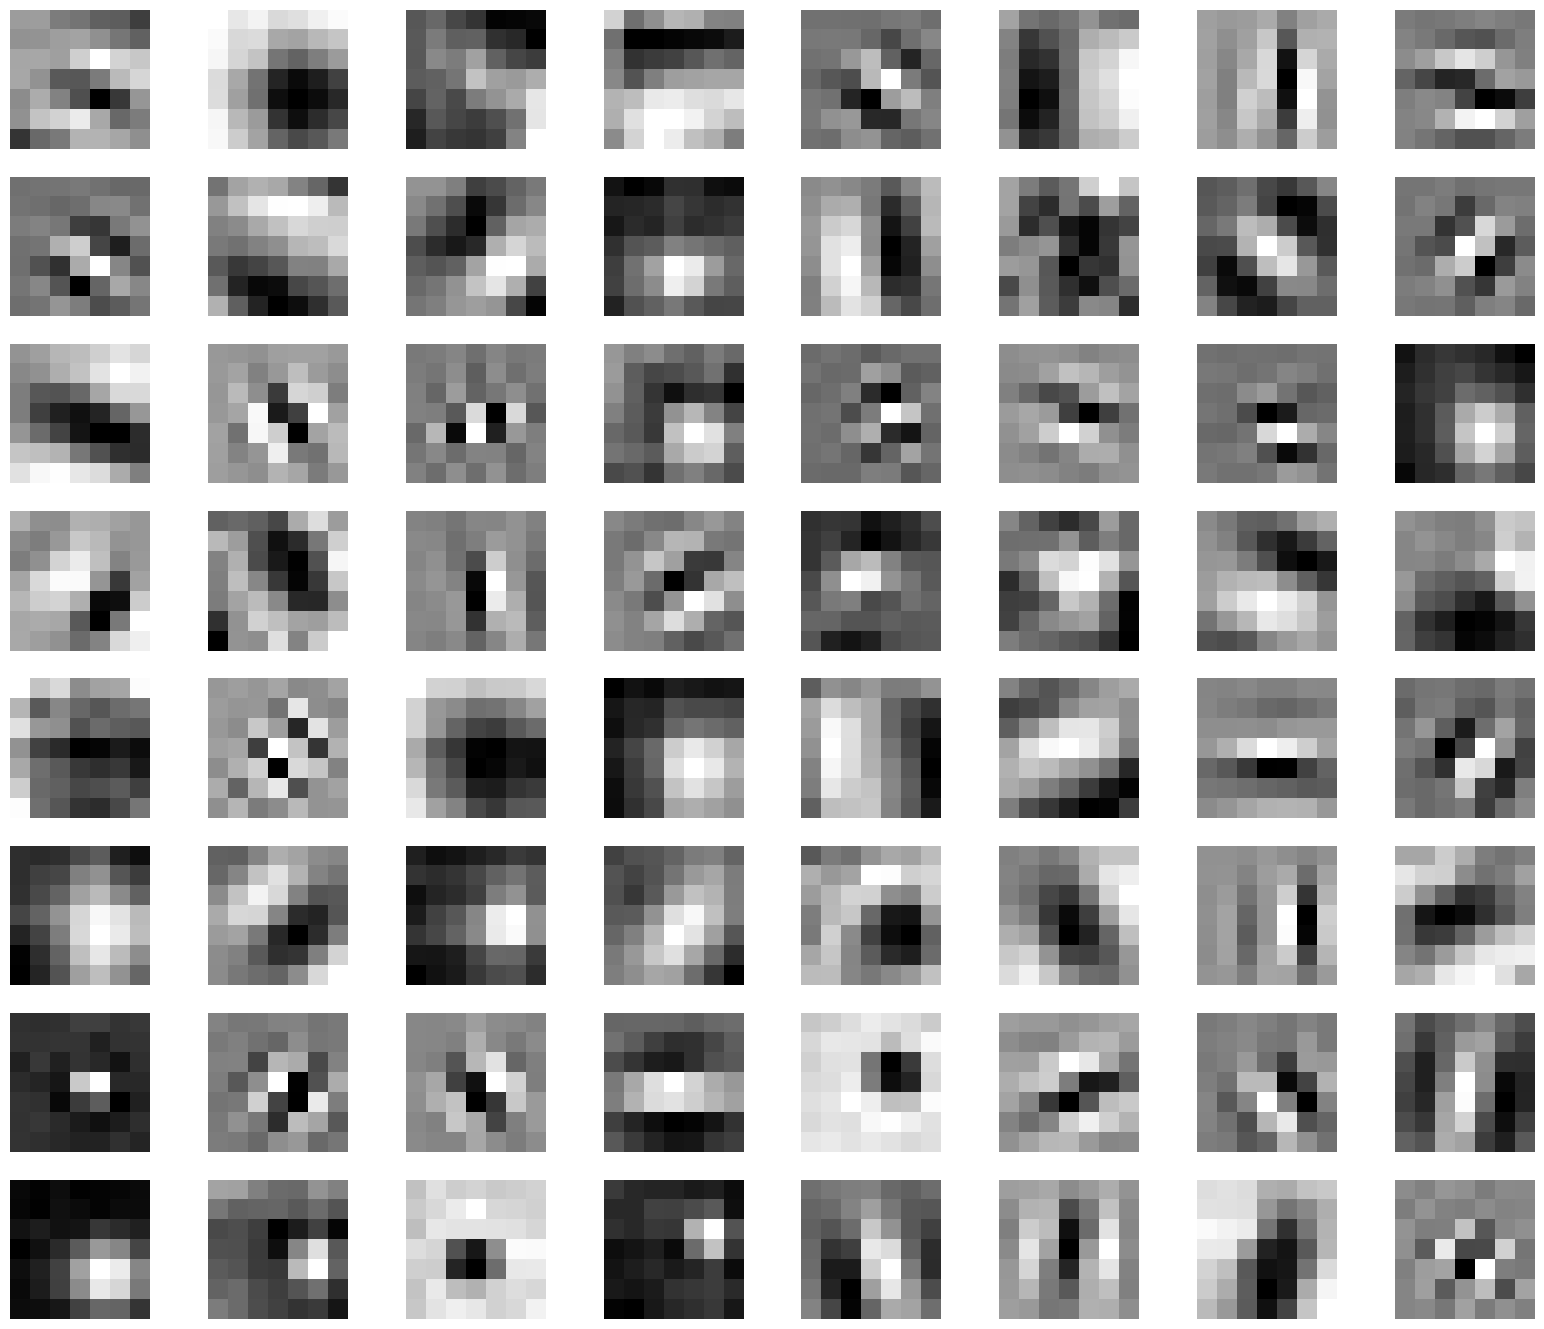

In [6]:
# visualize the filters of the first conv layer
layer = 0

plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[layer]):
    # get the filter you want to visualise
    plt.subplot(8, 8, i+1) # the number of subplots should be as many as the filters we want to visualise
    plt.imshow(filter[layer, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

From the visualization of the convolutional layer filters above, we can see that different kernels focus on different shapes, e.g., diagonal lines, squares, etc. 

Now that we are familiar with the model and the filters, we can see how increasingly complex features are learned in different layers.

### Viasualizing Feature Maps of an Image

Let's start choosing an image and preparing as follows:

- define the image transformation, which first converts the image to PIL format, resizes it to a standard dimension of 512x512, changes the dtype to torch tensor, and normalises the image to the 0-1 range
- add the batch dimension to the existing image dimension 

*Note: that DL models are trained in batches of images, but in our case we have only one image, so we add a batch dimension of size 1. Now, the size of_ the image, instead of being [3, 512, 512], is [1, 3, 512, 512], indicating that there is only one image in the batch.*

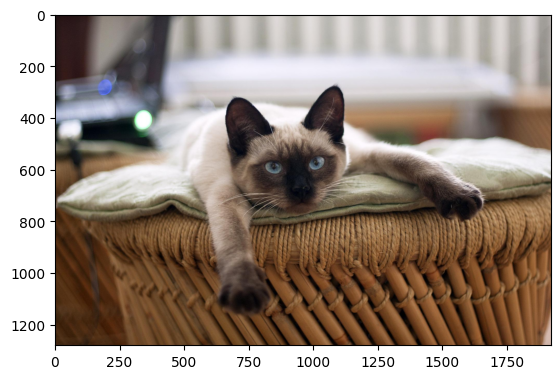

Tensor size before adding batch dimension: torch.Size([3, 512, 512])
Tensor size after adding batch dimension: torch.Size([1, 3, 512, 512])


In [7]:
# read and visualize an image
img = cv.imread("../data/images/cat.jpg") # Insert the path to image.
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms (here we are using the ImageNet transformations)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = np.array(img)

# apply the transforms
img = transform(img)
print(f"Tensor size before adding batch dimension: {img.size()}")

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(f"Tensor size after adding batch dimension: {img.size()}")

To visualize the feature maps of the image after passing it through the convolutional layers of the ResNet-50 model, we have to pass the image through each convolutional layer and save each layer’s output. Afterwards we can visualize the feature map blocks of each layer.

The final layers (near the final fully connected layer) have many feature maps, in the range of 512 to 2048 (check the model architecture). We will only visualize 64 feature maps from a layer at the beginning of the model, in the middle, and in the final convolutional layer.

Size of layer 1 is: torch.Size([64, 256, 256])
Feature maps from the first convolutional layer (layer 0) of ResNet-50 model


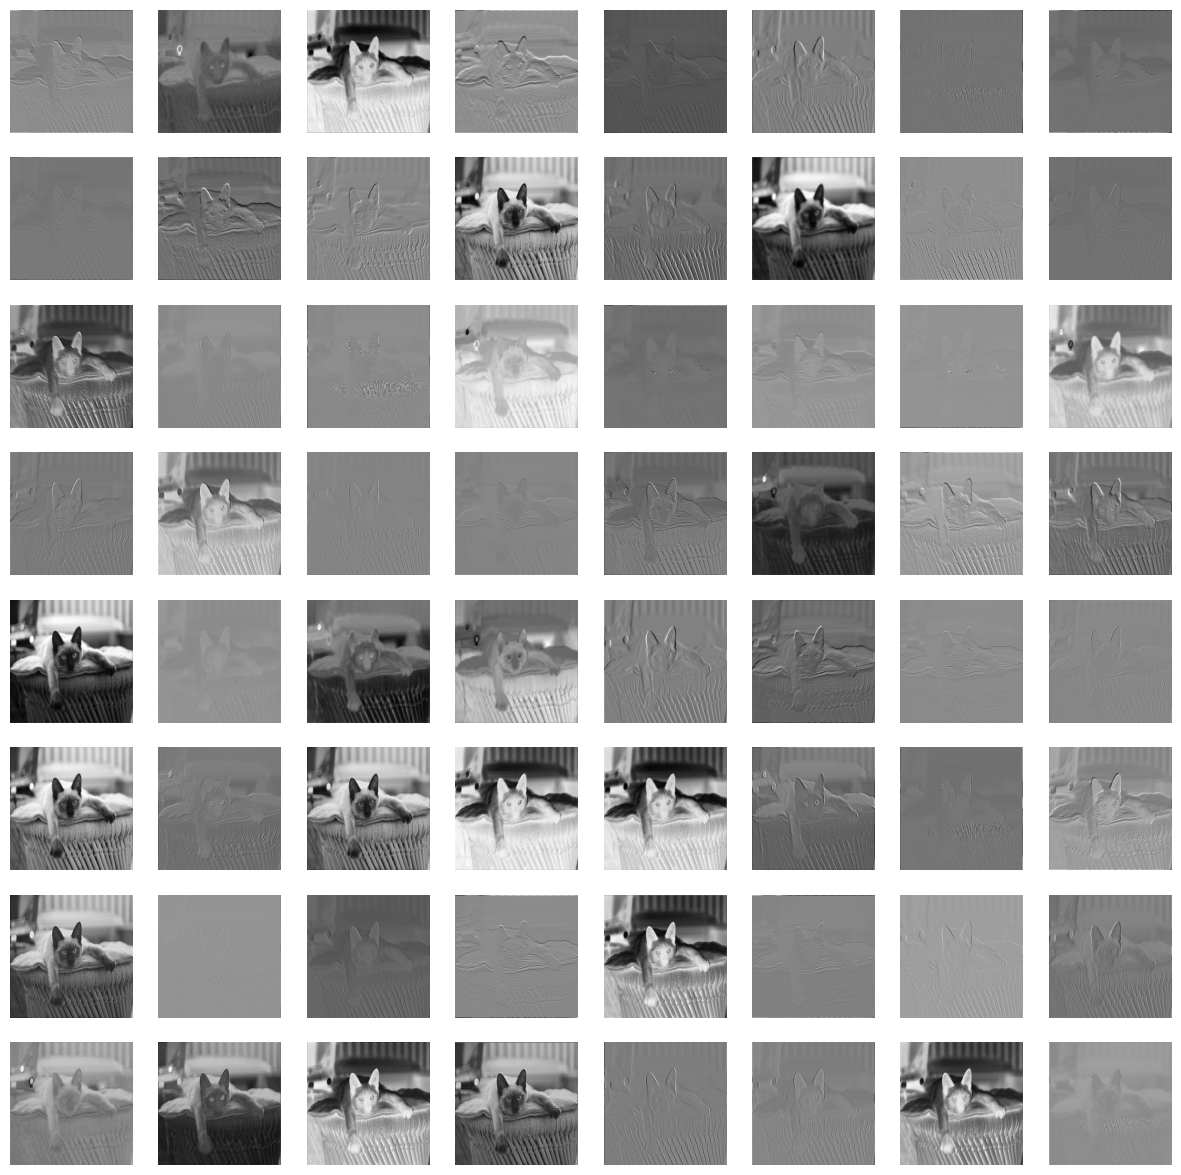

Size of layer 25 is: torch.Size([1024, 64, 64])
Feature maps from the first convolutional layer (layer 24) of ResNet-50 model


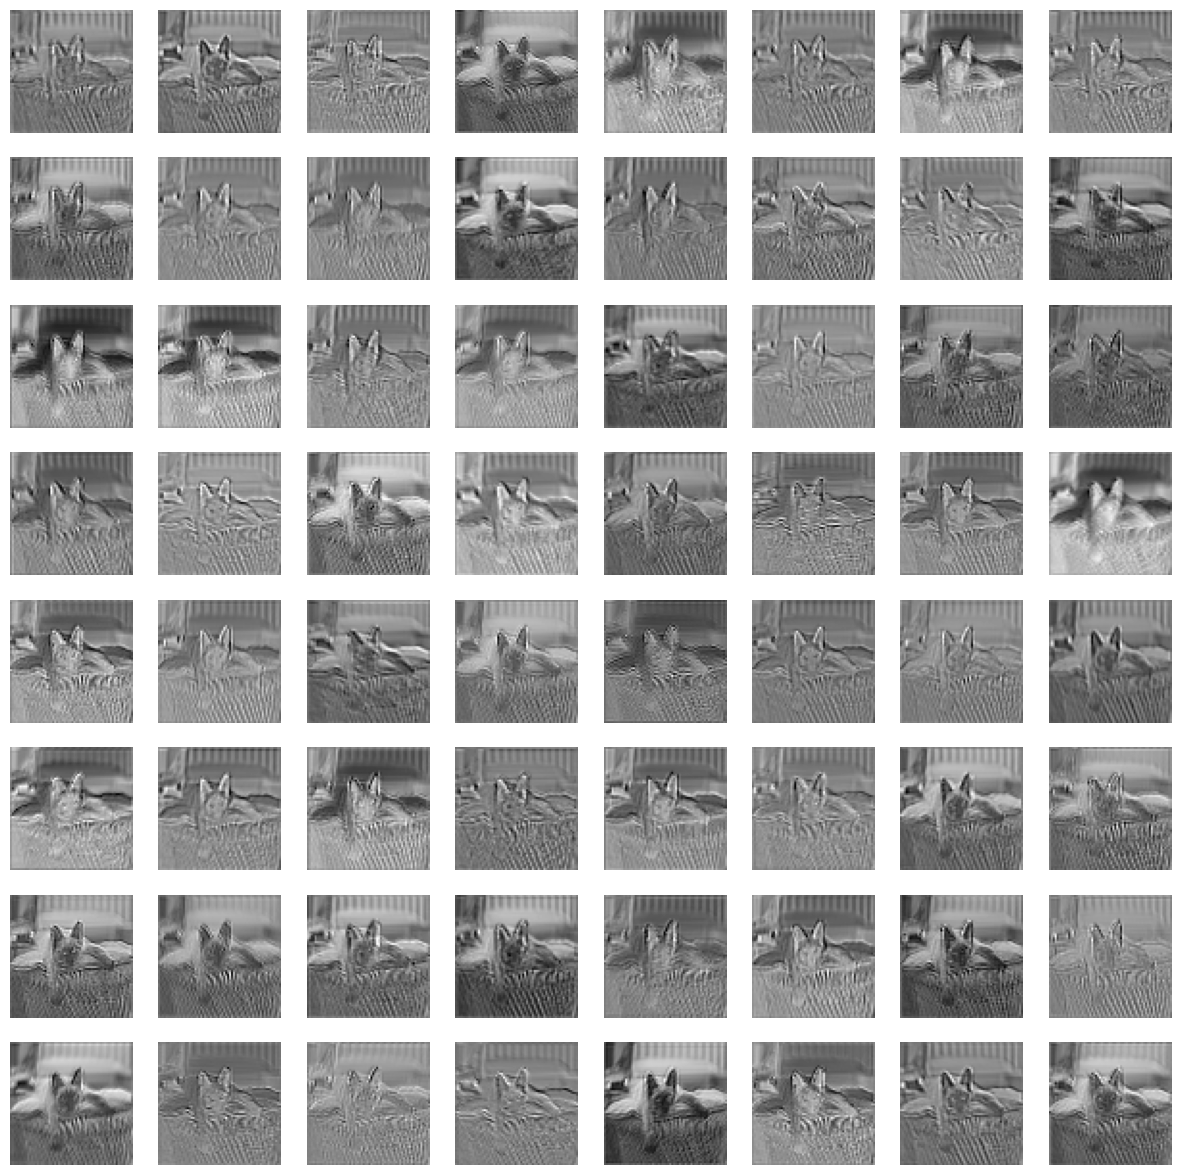

Size of layer 49 is: torch.Size([2048, 32, 32])
Feature maps from the first convolutional layer (layer 48) of ResNet-50 model


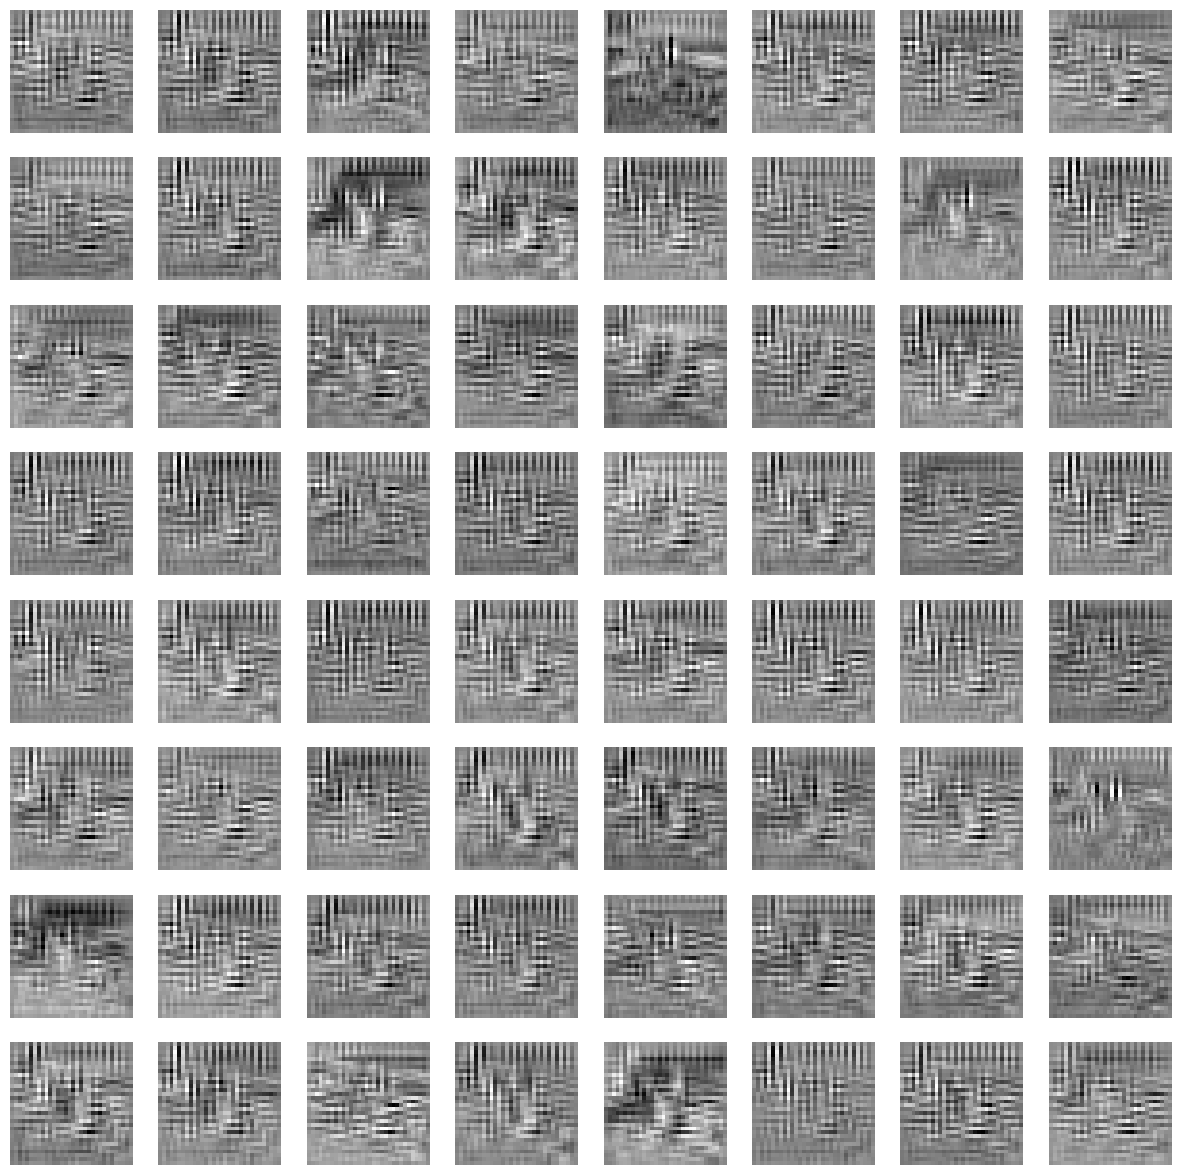

In [8]:
# layers we want to visualize
layers = [0,24,48]

# pass the image through first layer
results = [conv_layers[0] (img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

# then iterate through layers we want to vsualize
for layer in layers:
    
    layer_viz = results[layer][0, :, :, :]
    layer_viz = layer_viz.data

    print(f'Size of layer {layer+1} is: {layer_viz.size()}')
    print(f'Feature maps from the first convolutional layer (layer {layer}) of ResNet-50 model')
    
    plt.figure(figsize=(15, 15))
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

<font color='green'>

#### Question 1: What do you notice when looking at the feature maps at the beginning, middle, and end of the model?

<font color='grey'>

#### Your Answer: 


<font color='green'>

#### Question 2: We only plotted a tiny subset of the feature maps for one specific image! How much work would it be to review all the feature maps and kernels to understand why a model makes a specific prediction?

<font color='grey'>

#### Your Answer: 
